In this notebook, we'll be implementing exmples from Chen's torchdiffeqn python library:

 - Original Paper: https://arxiv.org/pdf/1806.07366.pdf
 - Medium article: https://github.com/rtqichen/torchdiffeq
 - PINN vs NeuroODE: https://esciencegroup.com/2020/06/10/notes-on-deep-learning-and-differential-equations/

# Libraries

In [123]:
from torchdiffeq import odeint
import torch
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import *
from matplotlib.animation import FuncAnimation
import torch
from torch import nn
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.optim import Adam
import numpy as np
device = 'cpu'
N = 100

# Forward simulation

In [124]:
true_y0 = torch.tensor([[2., 0.]]).to(device)
t = torch.linspace(0., 25., N).to(device)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)

In [125]:
class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y, true_A)

In [126]:
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

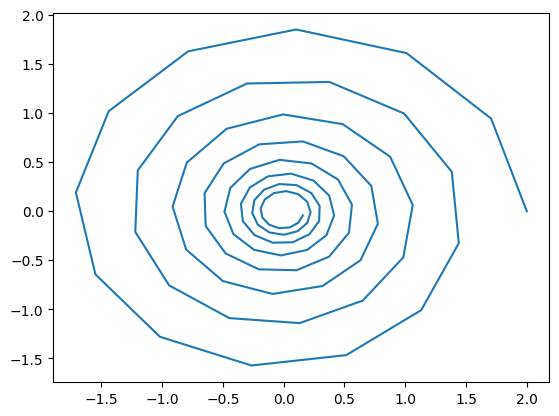

In [127]:
results = true_y.squeeze().numpy()
plt.plot(results[:,0],results[:,1])

# Learning the dynamical system: Pure neural network

In [142]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [149]:
def get_batch(t,y_true,batch_time = 10,batch_size = 10):
    d_size = y_true.size()[0]
    start = torch.from_numpy(np.random.choice(np.arange(d_size - batch_time, dtype=np.int64), batch_size, replace=False))# Generate random starting point
    y0_batch = y_true[start]
    t_batch = t[:batch_time]
    y_batch = torch.stack([y_true[start + i] for i in range(10)], dim=0)
    return y_batch, t_batch, y0_batch 

In [150]:
def optimise(optimiser,func,y0, t,y_true):
    optimiser.zero_grad()
    pred_y = odeint(func, y0, t)
    loss = (pred_y - y_true).pow(2).mean()
    loss.backward()
    optimiser.step()
    return loss

In [155]:
y_true = torch.from_numpy(results)
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
full_loss_vector = []
iteration_vector =[]
for i in range(300):
    y_batch, t_batch,y0_batch = get_batch(t,y_true)
    loss = optimise(optimizer,func,y0_batch, t_batch,y_batch)
    if i % 10==0:
        iteration_vector.append(i)
        full_loss_vector.append(loss.detach().numpy())


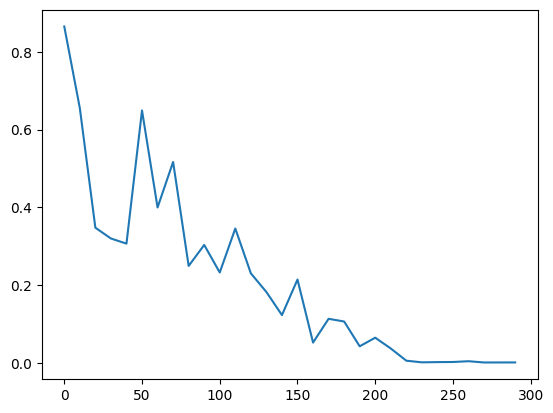

In [156]:
plt.plot(iteration_vector,full_loss_vector)

In [157]:
t_predict = torch.linspace(0., 25., 1000).to(device)
with torch.no_grad():
    y_predict = odeint(func, true_y0, t_predict, method='dopri5')

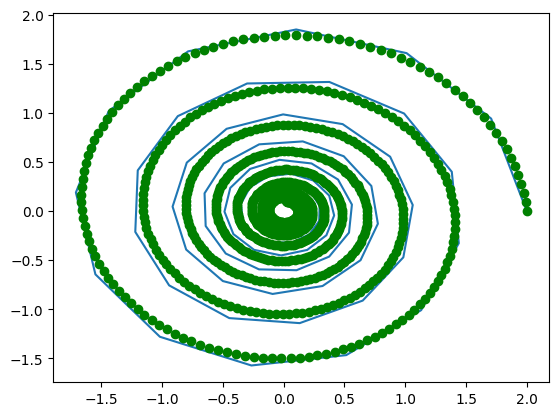

In [158]:
results = true_y.squeeze().numpy()
y_predict_np = y_predict.squeeze().numpy()
plt.plot(results[:,0],results[:,1])
plt.plot(y_predict_np[:,0],y_predict_np[:,1],'go')

# Learning the dynamical system: With structural constraints

In [183]:
class ODEFunc_Structure(nn.Module):
    def __init__(self,l1_init = 0.0):
        super(ODEFunc_Structure, self).__init__()
        # Register the parameters
        self.M = nn.Parameter(torch.tensor([[l1_init,l1_init],[l1_init,l1_init]], requires_grad=True).float())
        self.register_parameter("M",self.M)
        
    def forward(self, t, y):
        return torch.mm(y,self.M)

In [184]:
func = ODEFunc_Structure()
[t for t in func.parameters()]

[Parameter containing:
 tensor([[0., 0.],
         [0., 0.]], requires_grad=True)]

In [185]:
y_true = torch.from_numpy(results)
func = ODEFunc_Structure().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-1)
full_loss_vector = []
iteration_vector =[]
for i in range(300):
    y_batch, t_batch,y0_batch = get_batch(t,y_true)
    loss = optimise(optimizer,func,y0_batch, t_batch,y_batch)
    if i % 10==0:
        iteration_vector.append(i)
        full_loss_vector.append(loss.detach().numpy())


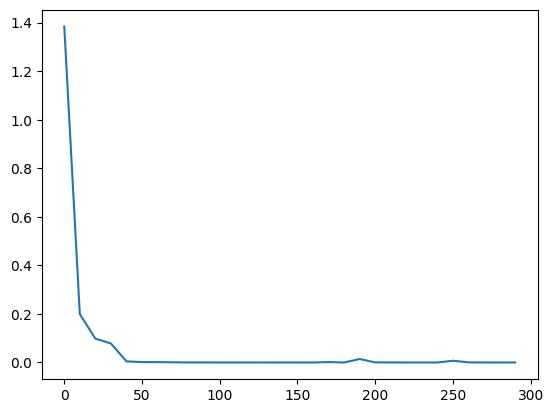

In [186]:
plt.plot(iteration_vector,full_loss_vector)

In [187]:
[p for p in func.parameters()]

[Parameter containing:
 tensor([[-0.1016,  1.9987],
         [-2.0009, -0.1031]], requires_grad=True)]

In [188]:
t_predict = torch.linspace(0., 25., 1000).to(device)
with torch.no_grad():
    y_predict = odeint(func, true_y0, t_predict, method='dopri5')

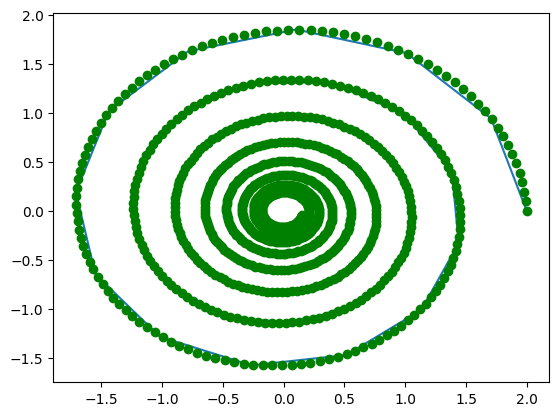

In [189]:
results = true_y.squeeze().numpy()
y_predict_np = y_predict.squeeze().numpy()
plt.plot(results[:,0],results[:,1])
plt.plot(y_predict_np[:,0],y_predict_np[:,1],'go')

# Forward simuation wih a time varying parameter